# Line ratio grids
Produce and plot grids of line ratios for a variety of complex star formation histories.

## Imports

In [2]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, NormalPrior
from lightning.plots import step_curve
from lightning.sfh import DelayedExponentialSFH

## Setup

Create three Lightning objects, loading the Cloudy grids with and without dust grains, and with ULXs from Garofali+(2024) for BPASS stellar population models.

In [5]:
filter_labels = ['SDSS_u'] # We aren't actually using these, 'None' just isn't an option

agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 10))

lgh_nodust = Lightning(filter_labels,
                       lum_dist=15, # also isn't going to come up
                       ages=agebins,
                       nebula_lognH=2.0,
                       nebula_dust=False,
                       stellar_type='BPASS-A24',
                       SFH_type='Piecewise-Constant',
                       atten_type='Modified-Calzetti',
                       print_setup_time=True)
print()
lgh_dust = Lightning(filter_labels,
                     lum_dist=15,
                     ages=agebins,
                     nebula_lognH=2.0,
                     nebula_dust=True,
                     stellar_type='BPASS-A24',
                     SFH_type='Piecewise-Constant',
                     atten_type='Modified-Calzetti',
                     print_setup_time=True)

print()
lgh_ULX = Lightning(filter_labels,
                     lum_dist=15,
                     ages=agebins,
                     nebula_lognH=2.0,
                     nebula_dust=True,
                     stellar_type='BPASS-ULX-G24',
                     SFH_type='Piecewise-Constant',
                     atten_type='Modified-Calzetti',
                     print_setup_time=True)

0.002 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
1.105 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.000 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.107 s elapsed total

0.001 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
1.051 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.000 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.052 s elapsed total

0.001 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.997 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.000 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
0.998 s elapsed total


## Define SFH templates

For simplicity we'll convolve a delayed exponential SFH with the age bins.

Text(0, 0.5, '${\\rm SFR}(t)~[\\rm M_{\\odot}~yr^{-1}]$')

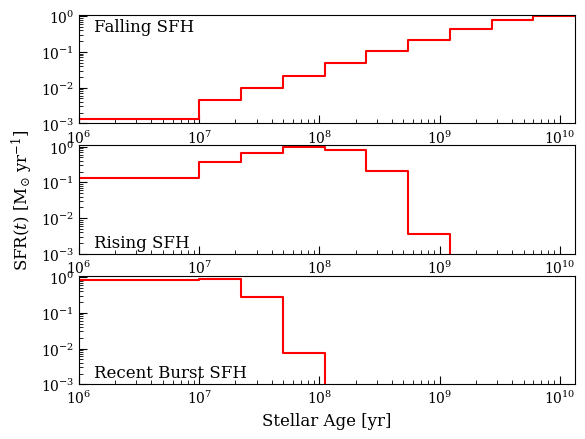

In [4]:
agemid = 0.5 * np.array(agebins[:-1]) + 0.5 * np.array(agebins[1:])
sfh_exp = DelayedExponentialSFH(agemid)


falling_sfh =  sfh_exp.evaluate(np.array([np.exp(1), 1e10]))
rising_sfh = sfh_exp.evaluate(np.array([np.exp(1), 1e8]))
recent_sfh = sfh_exp.evaluate(np.array([np.exp(1), 1e7]))

fig, axs = plt.subplots(3,1)

x,y = step_curve(agebins, falling_sfh)
axs[0].plot(x,y, color='red')

# x,y = step_curve(agebins, rising_sfh)
# axs[1].plot(x,y)
x,y = step_curve(agebins, rising_sfh)
axs[1].plot(x,y, color='red')

# x,y = step_curve(agebins, recent_sfh)
# axs[2].plot(x,y)
x,y = step_curve(agebins, recent_sfh)
axs[2].plot(x,y, color='red')

for i in [0,1,2]:
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim(1e6, 13.4e9)
    axs[i].set_ylim(1e-3, 1.1)

axs[0].text(0.03, 0.97, 'Falling SFH', ha='left', va='top', transform=axs[0].transAxes)
axs[1].text(0.03, 0.03, 'Rising SFH', ha='left', va='bottom', transform=axs[1].transAxes)
axs[2].text(0.03, 0.03, 'Recent Burst SFH', ha='left', va='bottom', transform=axs[2].transAxes)


axs[2].set_xlabel('Stellar Age [yr]')
axs[1].set_ylabel(r'${\rm SFR}(t)~[\rm M_{\odot}~yr^{-1}]$')

And now we'll derive grids of line ratios for our various faked SFHs:

## Dusty grid

Text(0.03, 0.97, 'Cloudy grid w/ dust')

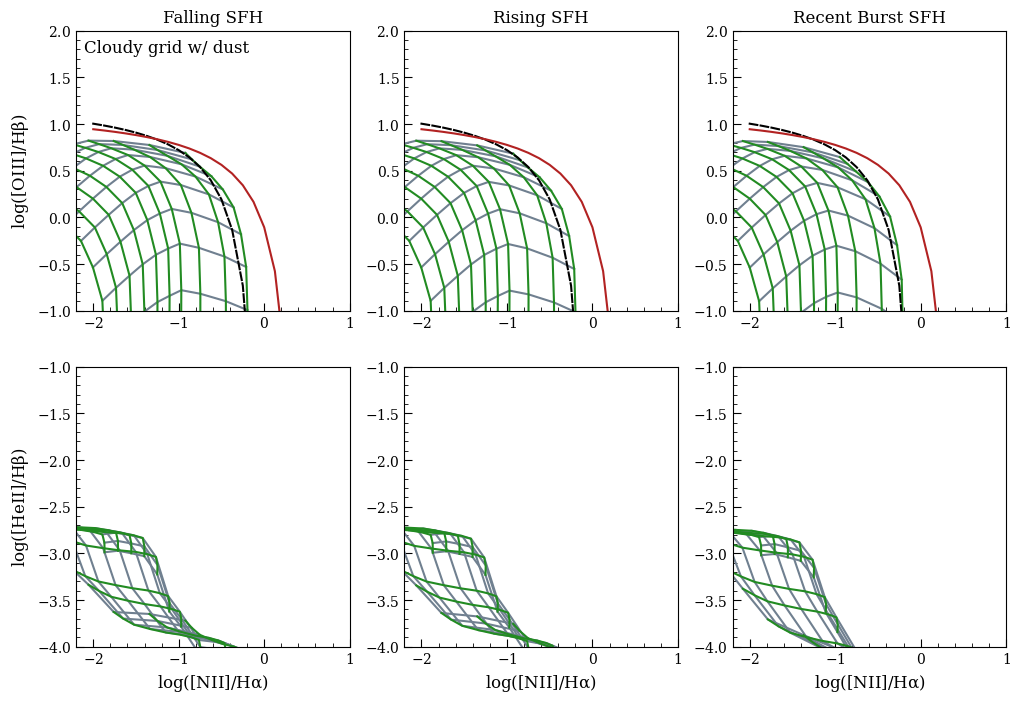

In [29]:
from python_snippets import k06_NIIplot

Npoints = 10

logU_grid = np.linspace(-4, -1.5, Npoints)
Z_grid = np.logspace(np.log10(0.00075), np.log10(0.02), Npoints)

tauV_grid = np.array([0.0])

fig, axs = plt.subplots(2,3, figsize=(12,8))

linestyle=['-','--']

OIIImask = lgh_dust.stars.line_labels == 'O__3_500684A'
Halphamask = lgh_dust.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh_dust.stars.line_labels == 'H__1_486132A'
NIImask = lgh_dust.stars.line_labels == 'N__2_658345A'

HeIImask = lgh_dust.stars.line_labels == 'HE_2_468568A'

for m,sfh in enumerate([falling_sfh, rising_sfh, recent_sfh]):
    for k,tauV in enumerate(tauV_grid):

        param_array = np.zeros(15)
        param_array[:10] = sfh
        param_array[-3] = tauV

        line_grid = np.zeros((Npoints,Npoints,len(lgh_nodust.stars.line_labels)))
        
        for i,logU in enumerate(logU_grid):
            for j,Z in enumerate(Z_grid):

                param_array[10] = Z
                param_array[11] = logU

                lines_ext, lines_intr = lgh_dust.get_model_lines(param_array)
                
                line_grid[i,j,:] = lines_ext.flatten()

        o3hbeta_grid = np.log10(line_grid[:,:,OIIImask] / line_grid[:,:,Hbetamask])
        n2halpha_grid = np.log10(line_grid[:,:,NIImask] / line_grid[:,:,Halphamask])
        he2hbeta_grid =  np.log10(line_grid[:,:,HeIImask] / line_grid[:,:,Hbetamask])

        for i,_ in enumerate(logU_grid):
            axs[0,m].plot(n2halpha_grid[i,:], o3hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[i,:], he2hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
        
        for j,_ in enumerate(Z_grid):
            axs[0,m].plot(n2halpha_grid[:,j], o3hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[:,j], he2hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])

        k06_NIIplot(ax=axs[0,m])
        axs[0,m].set_xlim(-2.2,1)
        axs[0,m].set_ylim(-1,2)

        axs[1,m].set_xlim(-2.2,1)
        axs[1,m].set_ylim(-4,-1)

axs[0,0].set_title('Falling SFH')
axs[0,1].set_title('Rising SFH')
axs[0,2].set_title('Recent Burst SFH')

axs[0,0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[1,0].set_ylabel(r'$\rm \log([He II] / H\beta)$')
for m in [0,1,2]:
    axs[1, m].set_xlabel(r'$\rm \log([N II] / H\alpha)$')

axs[0,0].text(0.03, 0.97, 'Cloudy grid w/ dust', ha='left', va='top', transform=axs[0,0].transAxes)

## Grid without dust

Text(0.03, 0.97, 'Cloudy grid w/o dust')

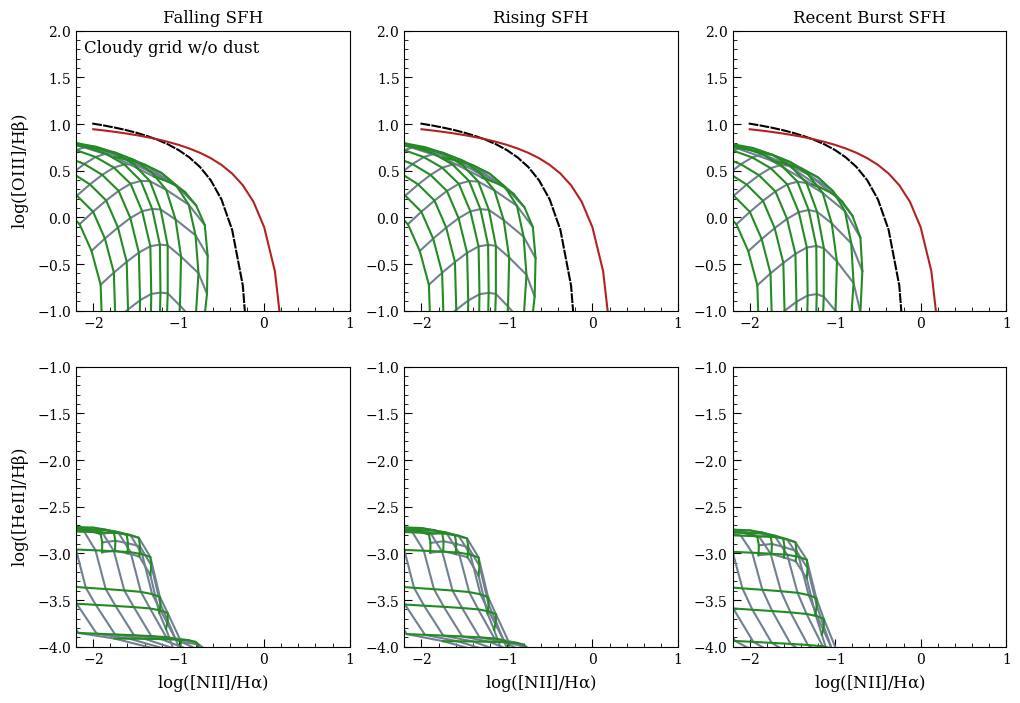

In [28]:
from python_snippets import k06_NIIplot

Npoints = 10

logU_grid = np.linspace(-4, -1.5, Npoints)
Z_grid = np.logspace(np.log10(0.00075), np.log10(0.02), Npoints)

tauV_grid = np.array([0.0])

fig, axs = plt.subplots(2,3, figsize=(12,8))

linestyle=['-','--']

OIIImask = lgh_nodust.stars.line_labels == 'O__3_500684A'
Halphamask = lgh_nodust.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh_nodust.stars.line_labels == 'H__1_486132A'
NIImask = lgh_nodust.stars.line_labels == 'N__2_658345A'

HeIImask = lgh_nodust.stars.line_labels == 'HE_2_468568A'

for m,sfh in enumerate([falling_sfh, rising_sfh, recent_sfh]):
    for k,tauV in enumerate(tauV_grid):

        param_array = np.zeros(15)
        param_array[:10] = sfh
        param_array[-3] = tauV

        line_grid = np.zeros((Npoints,Npoints,len(lgh_nodust.stars.line_labels)))
        
        for i,logU in enumerate(logU_grid):
            for j,Z in enumerate(Z_grid):

                param_array[10] = Z
                param_array[11] = logU

                lines_ext, lines_intr = lgh_nodust.get_model_lines(param_array)
                
                line_grid[i,j,:] = lines_ext.flatten()

        o3hbeta_grid = np.log10(line_grid[:,:,OIIImask] / line_grid[:,:,Hbetamask])
        n2halpha_grid = np.log10(line_grid[:,:,NIImask] / line_grid[:,:,Halphamask])
        he2hbeta_grid =  np.log10(line_grid[:,:,HeIImask] / line_grid[:,:,Hbetamask])

        for i,_ in enumerate(logU_grid):
            axs[0,m].plot(n2halpha_grid[i,:], o3hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[i,:], he2hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
        
        for j,_ in enumerate(Z_grid):
            axs[0,m].plot(n2halpha_grid[:,j], o3hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[:,j], he2hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])

        k06_NIIplot(ax=axs[0,m])
        axs[0,m].set_xlim(-2.2,1)
        axs[0,m].set_ylim(-1,2)

        axs[1,m].set_xlim(-2.2,1)
        axs[1,m].set_ylim(-4,-1)

axs[0,0].set_title('Falling SFH')
axs[0,1].set_title('Rising SFH')
axs[0,2].set_title('Recent Burst SFH')

axs[0,0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[1,0].set_ylabel(r'$\rm \log([He II] / H\beta)$')
for m in [0,1,2]:
    axs[1, m].set_xlabel(r'$\rm \log([N II] / H\alpha)$')

axs[0,0].text(0.03, 0.97, 'Cloudy grid w/o dust', ha='left', va='top', transform=axs[0,0].transAxes)

## Grid with ULXs

Text(0.03, 0.97, 'Cloudy grid w/ ULXs')

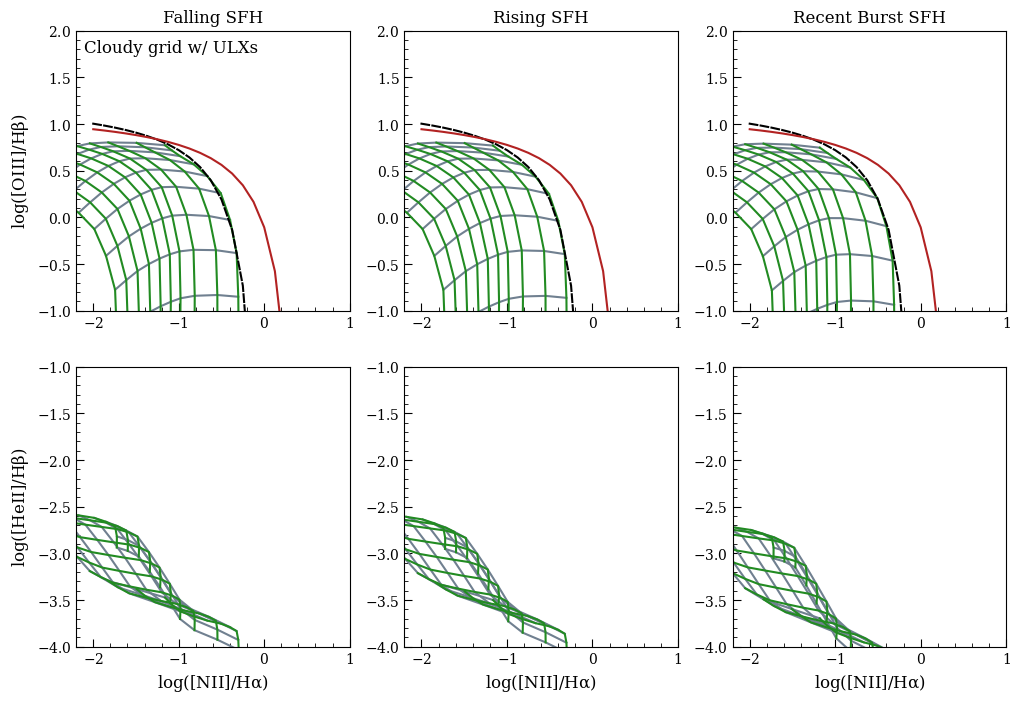

In [25]:
from python_snippets import k06_NIIplot

Npoints = 10

logU_grid = np.linspace(-4, -1.5, Npoints)
Z_grid = np.logspace(np.log10(lgh_ULX.stars.param_bounds[0,0]), np.log10(lgh_ULX.stars.param_bounds[0,1]), Npoints)

tauV_grid = np.array([0.0])

fig, axs = plt.subplots(2,3, figsize=(12,8))

linestyle=['-','--']

OIIImask = lgh_ULX.stars.line_labels == 'O__3_500684A'
Halphamask = lgh_ULX.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh_ULX.stars.line_labels == 'H__1_486132A'
NIImask = lgh_ULX.stars.line_labels == 'N__2_658345A'

HeIImask = lgh_ULX.stars.line_labels == 'HE_2_468568A'

for m,sfh in enumerate([falling_sfh, rising_sfh, recent_sfh]):
    for k,tauV in enumerate(tauV_grid):

        param_array = np.zeros(15)
        param_array[:10] = sfh
        param_array[-3] = tauV

        line_grid = np.zeros((Npoints,Npoints,len(lgh_nodust.stars.line_labels)))
        
        for i,logU in enumerate(logU_grid):
            for j,Z in enumerate(Z_grid):

                param_array[10] = Z
                param_array[11] = logU

                lines_ext, lines_intr = lgh_ULX.get_model_lines(param_array)
                
                line_grid[i,j,:] = lines_ext.flatten()

        o3hbeta_grid = np.log10(line_grid[:,:,OIIImask] / line_grid[:,:,Hbetamask])
        n2halpha_grid = np.log10(line_grid[:,:,NIImask] / line_grid[:,:,Halphamask])
        he2hbeta_grid =  np.log10(line_grid[:,:,HeIImask] / line_grid[:,:,Hbetamask])

        for i,_ in enumerate(logU_grid):
            axs[0,m].plot(n2halpha_grid[i,:], o3hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[i,:], he2hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
        
        for j,_ in enumerate(Z_grid):
            axs[0,m].plot(n2halpha_grid[:,j], o3hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])
            axs[1,m].plot(n2halpha_grid[:,j], he2hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])

        k06_NIIplot(ax=axs[0,m])
        axs[0,m].set_xlim(-2.2,1)
        axs[0,m].set_ylim(-1,2)

        axs[1,m].set_xlim(-2.2,1)
        axs[1,m].set_ylim(-4,-1)

axs[0,0].set_title('Falling SFH')
axs[0,1].set_title('Rising SFH')
axs[0,2].set_title('Recent Burst SFH')

axs[0,0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
axs[1,0].set_ylabel(r'$\rm \log([He II] / H\beta)$')
for m in [0,1,2]:
    axs[1, m].set_xlabel(r'$\rm \log([N II] / H\alpha)$')

axs[0,0].text(0.03, 0.97, 'Cloudy grid w/ ULXs', ha='left', va='top', transform=axs[0,0].transAxes)

In [10]:
lgh_ULX.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi               Description
--------- --- --- -------------------------
    psi_1 0.0 inf  SFR in stellar age bin 1
    psi_2 0.0 inf  SFR in stellar age bin 2
    psi_3 0.0 inf  SFR in stellar age bin 3
    psi_4 0.0 inf  SFR in stellar age bin 4
    psi_5 0.0 inf  SFR in stellar age bin 5
    psi_6 0.0 inf  SFR in stellar age bin 6
    psi_7 0.0 inf  SFR in stellar age bin 7
    psi_8 0.0 inf  SFR in stellar age bin 8
    psi_9 0.0 inf  SFR in stellar age bin 9
   psi_10 0.0 inf SFR in stellar age bin 10

BPASS-Stellar-A24
Parameter                   Lo                   Hi                                                   Description
--------- -------------------- -------------------- -------------------------------------------------------------
     Zmet 0.001071519305237607 0.016982436524617443 Metallicity (mass fraction, where solar = 0.020 ~ 10**[-1.7])
     logU                 -4.0                 -1.5                             log10 of th

In [14]:
np.log10(0.00107)

-2.9706162223147903

In [15]:
10**-2.97

0.001071519305237606